In [ ]:
#imports
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import os
import requests
import base64
import logging
import spacy
from spacy_langdetect import LanguageDetector
from bs4 import BeautifulSoup
import time


import matplotlib.pyplot as plt
import ast
from ast import literal_eval
from collections import Counter
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

import seaborn as sns

import re
from textblob import TextBlob
import numpy as np
from scipy.stats import shapiro


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from scipy.stats import ttest_rel
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

from imblearn.under_sampling import RandomUnderSampler

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

# Retrieving and preprocessing the data

## Spotify playlist and track retrieval

In [ ]:
# Set up your Spotify API credentials
# CLIENT_ID and CLIENT_SECRET are your Spotify application's client ID and secret
CLIENT_ID = "YOUR-SPOTIFY-CLIENT-ID"
CLIENT_SECRET = "YOUR-SPOTIFY-CLIENT-SECRET"

# Initialize the authentication manager for Spotify with your client credentials
# This will be used to handle OAuth 2.0 authentication with Spotify
auth_manager = SpotifyClientCredentials(CLIENT_ID, CLIENT_SECRET)

# Create a Spotify client object with the authentication manager
# This client will be used to make requests to the Spotify API
spotify = spotipy.Spotify(auth_manager=auth_manager)

- "CLIENT_ID" and "CLIENT_SECRET" are your Spotify application's credentials. These are necessary for authenticating with the Spotify Web API.
- "SpotifyClientCredentials" is used to create an authentication manager for handling OAuth 2.0 authentication with Spotify.
- Finally, you're creating a Spotify client object using spotipy, which will be used for making requests to the Spotify Web API.

In [ ]:
def get_access_token(client_id, client_secret):
    """
    Get an access token for Spotify API using client credentials flow.

    Parameters:
    client_id (str): Spotify Application's Client ID
    client_secret (str): Spotify Application's Client Secret

    Returns:
    str: Access token for Spotify API
    """

    # Combine the client ID and client secret into a single string 
    # and encode this string in Base64. This is required for Spotify API authentication.
    client_creds = f"{client_id}:{client_secret}"
    client_creds_b64 = base64.b64encode(client_creds.encode())

    # Define the URL for the token request
    token_url = "https://accounts.spotify.com/api/token"
    
    # Set the data payload for the POST request. 
    # 'client_credentials' indicates that we're using the Client Credentials flow.
    token_data = {
        "grant_type": "client_credentials"
    }

    # Set the headers for the POST request. 
    # The Authorization header contains the Base64 encoded client credentials.
    token_headers = {
        "Authorization": f"Basic {client_creds_b64.decode()}"
    }

    # Make the POST request to the Spotify Accounts service to get the access token.
    r = requests.post(token_url, data=token_data, headers=token_headers)

    # Check if the request was successful (status codes in the range of 200 to 299).
    # If not, raise an exception.
    if r.status_code not in range(200, 299):
        raise Exception("Could not authenticate client.")

    # Parse the response JSON to extract the access token.
    token_response_data = r.json()
    
    return token_response_data["access_token"]


- Encode Client Credentials: It encodes the "client_id" and "client_secret" as a Base64 string, which is required for the authentication request.
- Prepare and Make the Request: It sets up and sends a POST request to Spotify's token endpoint with the necessary data and headers.
- Error Handling: It checks the response status code to ensure the request was successful.
- Retrieve and Return the Token: It parses the JSON response to extract and return the access token.

In [ ]:
def search_for_playlists(access_token, query, total=50):
    """
    Search for Spotify playlists relevant to specific search terms.

    Parameters:
    access_token (str): Access token for Spotify API authentication
    query (str): The search query to find playlists (e.g., genre, artist name)
    total (int): Total number of playlists to fetch

    Returns:
    list: List of playlists up to the specified total number
    """
    
    playlists = []  # Initialize an empty list to store the playlists
    offset = 0  # Initialize the offset for pagination

    # Keep fetching playlists until the desired number is reached
    while len(playlists) < total:
        # Prepare the search URL with the query, type as playlist, limit, and offset
        search_url = f"https://api.spotify.com/v1/search?q={query}&type=playlist&limit=50&offset={offset}"

        # Set the headers for the request, including the Authorization header with the access token
        search_headers = {
            "Authorization": f"Bearer {access_token}"
        }

        # Make a GET request to the Spotify API
        response = requests.get(search_url, headers=search_headers)

        # Check if the request was successful; log a warning and break the loop if not
        if response.status_code not in range(200, 299):
            logging.warning(f"Error: {response.status_code} \nResponse: {response}")
            break

        # Parse the response JSON to extract playlist items
        search_results = response.json()
        items = search_results['playlists']['items']

        # Extend the playlists list with the newly fetched items
        playlists.extend(items)

        # If no items are returned (no more playlists), break the loop
        if not items:
            break

        # Increase the offset for the next batch of playlists
        offset += 50

    # Return the playlists, trimmed to the specified total number
    return playlists[:total]


- Initialize Variables: It initializes a list to store playlists and a variable for pagination offset.

- Search Loop: It uses a "while" loop to continuously fetch playlists until the desired number ("total") is reached.

- Construct Request: For each iteration, it constructs a GET request to the Spotify API's search endpoint, including query parameters for the search term, type of content (playlists), limit per request (50), and the current offset.

- Make Request and Handle Response: It sends the request and checks the response. If the response indicates an error, it logs a warning and stops further requests.

- Extract and Store Playlists: It extracts playlist data from the response and adds it to the list of playlists.

- Pagination Handling: It updates the offset after each request to fetch the next set of results.

- Result Trimming: Finally, it returns the list of playlists, trimmed to the specified "total" number.

In [ ]:
def get_playlists(access_token, search_terms):
    """
    Retrieves a unique set of playlists based on a list of search terms.

    Parameters:
    access_token (str): Access token for Spotify API authentication
    search_terms (list): A list of search terms for which to find playlists

    Returns:
    list: A list of unique playlists across all search terms
    """
    
    unique_playlists = {}  # Initialize a dictionary to store unique playlists by their ID

    # Iterate through each search term
    for term in search_terms:
        # Call search_for_playlists function for each term
        # The number of playlists per term is divided evenly across all terms
        playlists = search_for_playlists(access_token, term, 1000 // len(search_terms))

        # Iterate through the playlists returned for the term
        for playlist in playlists:
            # Use playlist ID as the key in the dictionary to ensure uniqueness
            # Store the entire playlist object as the value
            unique_playlists[playlist['id']] = playlist

    # Convert the dictionary values (unique playlists) to a list
    all_unique_playlists = list(unique_playlists.values())

    # Return the list of unique playlists
    return all_unique_playlists


- Initialize Dictionary: A dictionary "unique_playlists" is initialized to store playlists. The dictionary ensures that each playlist is stored only once, using the playlist ID as the key.

- Loop Through Search Terms: The function iterates over each search term provided.

- Fetch Playlists for Each Term: It calls "search_for_playlists" for each term. The total number of playlists to fetch is evenly distributed among all search terms (1000 // len(search_terms)).

- Store Unique Playlists: Each playlist fetched is stored in the "unique_playlists" dictionary. Using the playlist ID as the key ensures that each playlist is unique in the collection.

- Convert to List: The dictionary's values, which represent unique playlists, are converted into a list.

- Return Unique Playlists: The function returns a list of unique playlists across all provided search terms.

In [ ]:
def get_playlist_tracks(access_token, all_unique_playlists):
    """
    Retrieves tracks from a list of Spotify playlists.

    Parameters:
    access_token (str): Access token for Spotify API authentication
    all_unique_playlists (list): List of playlists to retrieve tracks from

    Returns:
    dict: Dictionary mapping playlist IDs to their respective tracks
    """

    playlist_dictionary = {}  # Initialize a dictionary to store tracks for each playlist

    # Loop through each playlist in the provided list
    for playlist in all_unique_playlists:
        playlist_id = playlist['id']  # Extract the ID of the playlist
        tracks = []  # Initialize a list to store the tracks of the current playlist

        try:
            # Fetch the tracks of the playlist using the Spotify API
            playlist_tracks = spotify.playlist_tracks(playlist_id)

            # Check if the playlist has items (tracks)
            if 'items' in playlist_tracks:
                # Iterate through each track in the playlist
                for item in playlist_tracks['items']:
                    track = item.get('track')  # Get the track object

                    # Ensure the track object is valid and contains data
                    if track:
                        # Create a tuple of artist name and ID for each artist in the track
                        artist_data = [(artist['name'], artist['id']) for artist in track['artists']]

                        # Construct a dictionary with relevant track data
                        track_data = {
                            "artist": artist_data,    # List of artists as tuples (name, ID)
                            "song_id": track['id'],   # ID of the track
                            "song_name": track['name'],  # Name of the track
                            "popularity": track['popularity']  # Popularity score of the track
                        }

                        # Append the track data to the tracks list
                        tracks.append(track_data)

        except Exception as e:
            # Print an error message if there's an issue processing a playlist
            print(f"Error occurred while processing playlist {playlist_id}: {e}")

        # Map the playlist ID to its tracks in the dictionary
        playlist_dictionary[playlist_id] = tracks

    # Return the dictionary containing all the playlists and their tracks
    return playlist_dictionary


This function goes through each playlist in the given list, fetches the tracks in each playlist using the Spotify API, and then organizes the track data in a dictionary, where the key is the playlist ID and the value is a list of tracks in that playlist. The track data includes artist information, song ID, song name, and popularity score. This function is useful for aggregating track data from multiple playlists in a structured format.

In [ ]:
def get_songs_dataframe(tracks):
    """
    Transforms a dictionary of tracks into a structured pandas DataFrame.

    Parameters:
    tracks (dict): Dictionary with playlist IDs as keys and lists of song dictionaries as values.

    Returns:
    DataFrame: A pandas DataFrame containing details about the songs and the playlists they belong to.
    """

    # Initialize an empty DataFrame with specific columns to store song data
    df = pd.DataFrame(columns=['song_name', 'song_id', 'artist_name', 'artist_id', 'popularity', 'playlist'])

    # Iterate over each playlist and its songs in the tracks dictionary
    for playlist, songs in tracks.items():
        for song in songs:
            # Extracting artist name and id from the first artist listed in the song data
            artist_name = song['artist'][0][0]  # Name of the first artist
            artist_id = song['artist'][0][1]    # ID of the first artist

            # Extracting other song details
            song_name = song['song_name']  # Name of the song
            song_id = song['song_id']      # ID of the song
            popularity = song['popularity']  # Popularity score of the song

            # Create a temporary DataFrame with the current song's data
            temp_df = pd.DataFrame({
                'playlist': [playlist],     # Playlist ID
                'song_name': [song_name],   # Song name
                'song_id': [song_id],       # Song ID
                'artist_name': [artist_name],  # Artist name
                'artist_id': [artist_id],    # Artist ID
                'popularity': [popularity]  # Popularity score
            })

            # Append the temporary DataFrame to the main DataFrame
            df = pd.concat([df, temp_df], ignore_index=True)

    # Group by song details to avoid duplication and aggregate playlists into a list
    grouped_df = df.groupby(['song_name', 'song_id', 'artist_name', 'artist_id']) \
                   .agg({'playlist': list, 'popularity': 'first'}) \
                   .reset_index()

    # Return the grouped and structured DataFrame
    return grouped_df


- Initialize DataFrame: It starts by initializing a pandas DataFrame with specific columns to store song data.

- Iterate Over Tracks: It iterates over each playlist and its corresponding songs (contained in the "tracks" dictionary).

- Data Extraction and DataFrame Creation: For each song, it extracts necessary details (like artist name, song name, etc.) and creates a temporary DataFrame for each song. This DataFrame is then appended to the main DataFrame.

- Group and Aggregate Data: After processing all songs, it groups the DataFrame by song details to avoid duplications. For each group, it aggregates playlists into a list and keeps the first value of "popularity".

- Return Structured DataFrame: Finally, it returns a grouped and structured DataFrame containing all the song details along with their associated playlists.

In [4]:
def remove_non_english_song_titles(songs):
    """
    Filters out non-English songs from a DataFrame based on their titles.

    Parameters:
    songs (DataFrame): A pandas DataFrame containing song data, with a column 'song_name'.

    Returns:
    DataFrame: A DataFrame containing only songs with English titles.
    """

    # Load the spacy model for English language, used for natural language processing tasks
    nlp = spacy.load('en_core_web_sm')
    
    # Define a function to detect the language of a given text
    def detect_language(text):
        # Process the text using the spacy model
        doc = nlp(text)
        # Return the detected language
        return doc._.language['language']

    # Register the language detector to be used with the spacy model
    LanguageDetectorFactory = LanguageDetector()
    spacy.Language.factory("language_detector", func=lambda nlp, name: LanguageDetectorFactory)

    # Add the language detector to the spacy model's processing pipeline
    nlp.add_pipe('language_detector', last=True)

    # Apply the language detection function to each song title in the DataFrame
    # This adds a new column 'language' to the DataFrame with the detected language for each song
    songs['language'] = songs['song_name'].apply(detect_language)

    # Filter the DataFrame to only include songs with English titles
    english_songs = songs[songs['language'] == 'en']
    
    # Return the filtered DataFrame
    return english_songs


This function processes a DataFrame of songs, detects the language of each song title, and filters out songs that are not in English. It uses "spaCy", a natural language processing library, along with "spacy-langdetect", a language detection plugin for spaCy. After detecting the language for each song title, it returns a new DataFrame containing only those songs with English titles.

In [ ]:
# Obtain an access token using your Spotify client credentials
# This token is needed to authenticate requests to the Spotify API
access_token = get_access_token(CLIENT_ID, CLIENT_SECRET)

# Define a list of search terms to be used for finding playlists on Spotify
# These terms cover a wide range of music genres and themes
search_terms = ['Sad Songs', 'Angry Rock', 'Heartbreak Ballads', 'Trap Soul', 'Beach Party', 
                '2010s Pop', 'Country Hits', 'Winter Warmers', 'R&B', 'Workout Pump', 
                'Hip Hop Gems', 'party', 'classical', 'rock', 'rap', 'blues', 'pop', 'Rock Classics']

# Retrieve a collection of unique playlists from Spotify based on the search terms
# The function get_playlists will use the provided search terms to find relevant playlists
# and return a unique list of these playlists
playlists = get_playlists(access_token, search_terms)

# Fetch the tracks from the retrieved playlists
# The function get_playlist_tracks will go through each playlist and collect information
# about the tracks in these playlists, such as the song name, artist, popularity, etc.
tracks = get_playlist_tracks(access_token, playlists)

# Transform the track data into a structured pandas DataFrame
# The function get_songs_dataframe organizes the track information into a tabular format,
# making it easier to analyze and process the data
songs = get_songs_dataframe(tracks)


- Access Token Retrieval: First, it retrieves an access token for the Spotify API using your client credentials. This token is required for all requests to the Spotify API.

- Defining Search Terms: It sets up a list of search terms that will be used to find a variety of playlists on Spotify, covering different genres and moods.

- Fetching Playlists: It then retrieves playlists from Spotify that match the specified search terms. Each term is used to search for relevant playlists, and the resulting playlists are compiled into a unique list to avoid duplicates.

- Collecting Tracks Data: The code fetches detailed information about the tracks in each of these playlists. This includes collecting data like the song's name, the artists involved, the song's popularity score, and so on.

- Creating a DataFrame: Finally, it organizes this tracks data into a pandas DataFrame, which provides a convenient and structured way to work with the data, whether for analysis, processing, or exporting.

In [6]:
def is_valid_song_name(song_name):
    # Regular expression to match allowed characters (English letters, spaces, parentheses)
    # Add any other characters you want to allow inside the square brackets
    pattern = re.compile(r'^[A-Za-z\s\(\)]+$')
    return bool(pattern.match(song_name))

In [8]:
songs.dropna(inplace=True)
english_songs =  remove_non_english_song_titles(songs)
filtered_english_songs = english_songs[english_songs['song_name'].apply(is_valid_song_name)]
filtered_english_songs = filtered_english_songs[filtered_english_songs['popularity'] > 25]

## Genius lyrics retrieval

In [ ]:
def fetch_lyrics_url(song_name, artist_name, genius_token):
    """
    Fetch the URL of a song's page on Genius, retrying up to 3 times.

    Parameters:
    song_name (str): Name of the song
    artist_name (str): Name of the artist
    genius_token (str): Access token for the Genius API

    Returns:
    str or None: URL of the song's page on Genius if found, otherwise None
    """

    # Set the authorization headers for the Genius API request
    headers = {'Authorization': f'Bearer {genius_token}'}

    # Base URL for the Genius API
    base_url = 'https://api.genius.com'
    # Construct the search URL
    search_url = base_url + '/search'
    # Combine song name and artist name for the query
    query = f"{song_name} {artist_name}"
    
    # Attempt to fetch the URL up to 3 times in case of failures
    for attempt in range(3):
        try:
            # Send a GET request to the Genius API with the search query
            response = requests.get(search_url, headers=headers, params={'q': query})
            # Raise an exception if the response status is not successful
            response.raise_for_status()

            # Parse the JSON response
            json_response = response.json()
            # Extract the search hits
            hits = json_response['response']['hits']

            # If there are hits, return the URL of the first hit's result
            if hits:
                return hits[0]['result']['url']
            # If no hits are found, return None
            return None

        except requests.RequestException as e:
            # Print the error and retry after waiting for 2 seconds
            print(f"Attempt {attempt + 1} failed: {e}")
            time.sleep(2)

    # Return None if all attempts fail
    return None

This function attempts to find the URL of a song's page on Genius by querying the Genius API with the song's name and the artist's name. It retries up to three times in case of request failures. If the song is found in the search results, the URL of the song's page on Genius is returned. If the song is not found or if all attempts fail, it returns "None".

In [ ]:
def scrape_lyrics_from_url(url):
    """
    Scrape lyrics from a given Genius song page URL.

    Parameters:
    url (str): URL of the song's page on Genius

    Returns:
    str or None: The scraped lyrics if successful, otherwise None
    """

    try:
        # Make a GET request to the provided URL to get the page content
        page = requests.get(url)
        # Parse the page content using BeautifulSoup to navigate the HTML
        html = BeautifulSoup(page.text, "html.parser")
        
        # Find all HTML elements that are marked as containing lyrics
        # These are 'div' elements with a specific attribute indicating they contain lyrics
        lyrics_containers = html.find_all("div", attrs={"data-lyrics-container": "true"})
        
        # Combine the text from all found lyrics containers
        # This is done by joining the text of each container with a newline separator
        # The strip() method is used to remove leading and trailing whitespace
        lyrics_text = "\n".join(container.get_text(separator="\n").strip() for container in lyrics_containers)
        
        # Check if any lyrics text was found and return it
        if lyrics_text:
            return lyrics_text
        else:
            # If no lyrics were found, print a message and return None
            print(f"No lyrics found at {url}")
            return None
    except Exception as e:
        # If an error occurs during the scraping process, print the error message and return None
        print(f"Error scraping lyrics from {url}: {e}")
        return None

This function scrapes the lyrics from a Genius song page. It uses the BeautifulSoup library to parse the HTML content of the page, finds all "div" elements that are marked to contain lyrics, and then combines the text from these elements. If no lyrics are found or if there's an error during the scraping process, it handles these cases appropriately.

In [ ]:
# Set the Genius API token for authentication
genius_token = 'fauNphw4f1OPUxhKpyXC3LmeMm56Y3EkSFGA2KvtRDdflxDko7RpxO0SyPnTQ1I6'

# Load the songs data from a CSV file into a pandas DataFrame
songs_df = pd.read_csv('merged_file.csv')

# Initialize an empty DataFrame to store song information along with lyrics
lyrics_df = pd.DataFrame()

# Iterate over the songs in the DataFrame, starting from the 5487th song (index 5486)
for index, row in songs_df.iloc[5486:].iterrows():
    # Extract song details from each row
    song_id = row['song_id']
    song_name = row['song_name']
    artist_name = row['artist_name']
    artist_id = row['artist_id']
    popularity = row['popularity']
    playlist = row['playlist']
    
    # Fetch the URL for the song's lyrics from Genius
    lyrics_url = fetch_lyrics_url(song_name, artist_name, genius_token)

    # Scrape the lyrics from the URL if it was successfully retrieved
    lyrics = scrape_lyrics_from_url(lyrics_url) if lyrics_url else None

    # Create a new DataFrame row with the song and its lyrics information
    new_row = pd.DataFrame({
        'song_id': [song_id], 
        'song_name': [song_name],
        'artist_id': [artist_id],
        'artist_name': [artist_name],
        'popularity': [popularity],
        'playlist': [playlist],
        'lyrics_url': [lyrics_url], 
        'lyrics': [lyrics]
    })

    # Append the new row to the lyrics DataFrame
    lyrics_df = pd.concat([lyrics_df, new_row], ignore_index=True)

# Remove rows where lyrics are not available (drop rows with NaN in the 'lyrics' column)
lyrics_df = lyrics_df.dropna(subset=['lyrics'])

# Filter out rows where the lyrics URL ends with 'annotated'
# This might indicate a specific type of Genius page that is not a standard song lyric page
real_songs = lyrics_df[~lyrics_df['lyrics_url'].str.endswith('annotated')]

# Further filter the data to include only songs with lyrics less than or equal to 4000 characters
real_songs = real_songs[real_songs['lyrics'].str.len() <= 4000]

# Save the filtered DataFrame to a CSV file
real_songs.to_csv("Final_songs_with_lyrics.csv")

This script processes a DataFrame of songs to fetch and scrape their lyrics from Genius. It starts from a specific index in the DataFrame, iterates through each song, fetches the lyrics URL, scrapes the lyrics, and stores this information in a new DataFrame. The script then applies filters to remove entries without lyrics, entries with URLs ending in 'annotated', and entries with excessively long lyrics, before saving the final curated set of songs with lyrics to a CSV file.

## Spotify song audio features retrieval

In [ ]:
# Reading your DataFrame
filepath = "YOUR-FILEPATH"
songs_df = pd.read_csv(filepath)
# Drop rows where 'valence' is null
songs_df.dropna(subset=['lyrics'], inplace=True)
print(songs_df.shape)

# Add columns for valence and energy
songs_df['valence'] = None
songs_df['energy'] = None

In [ ]:
# Function to get Spotify access token
def get_spotify_token(client_id, client_secret):
    auth_url = 'https://accounts.spotify.com/api/token'
    
    try:
        auth_response = requests.post(auth_url, {
            'grant_type': 'client_credentials',
            'client_id': client_id,
            'client_secret': client_secret,
        })
        auth_response.raise_for_status()
        
        auth_response_data = auth_response.json()
        return auth_response_data['access_token']
    
    except requests.exceptions.RequestException as e:
        print(f"Error getting Spotify token: {e}")
        return None

# Getting the access token
token = get_spotify_token(client_id, client_secret)

if token is not None:
    # Base URL for Spotify API
    base_url = 'https://api.spotify.com/v1/audio-features/'

    # Headers for the API request
    headers = {
        'Authorization': f'Bearer {token}'
    }

    # Loop through each song
    for index, row in songs_df.iterrows(): #songs_df.iloc[2000:].iterrows():
        song_id = row['song_id']
        try:
            response = requests.get(base_url + song_id, headers=headers)
            if response.status_code == 429:
                # Handle rate limiting by waiting for the recommended time
                retry_after = int(response.headers.get('Retry-After', 5))  # Default to 5 seconds if Retry-After is not provided
                print(f"Rate limited. Waiting for {retry_after} seconds...")
                time.sleep(retry_after)
                response = requests.get(base_url + song_id, headers=headers)  # Retry the request
            response.raise_for_status()
            audio_features = response.json()

            # Store the valence and energy in the DataFrame
            if 'valence' in audio_features and 'energy' in audio_features:
                songs_df.at[index, 'valence'] = audio_features['valence']
                songs_df.at[index, 'energy'] = audio_features['energy']
            else:
                print(f"Audio features not found for song {song_id}")

        except requests.exceptions.RequestException as e:
            print(f"Error processing song {song_id}: {e}")

        # Introduce a delay between API requests
        time.sleep(1)

In [21]:
songs_df.head()

,song_id,song_name,artist_id,artist_name,popularity,playlist,lyrics_url,lyrics,language,valence,energy
0,1Eb90nmqTrxylKFhcUzW8P,(Everything I Do) I Do It For You,3Z02hBLubJxuFJfhacLSDc,Bryan Adams,78,['2ubOXCCHl3ysPpRAKAwDwA'],https://genius.com/Bryan-adams-everything-i-do...,[Verse 1]\nLook into my eyes\nYou will see\nWh...,en,0.299,0.36
1,6eBK3edMW7bEzecF1eCezc,(Everything I Do) I Do It For You,3Z02hBLubJxuFJfhacLSDc,Bryan Adams,66,"['37i9dQZF1DX7L1VcqQ1quZ', '37i9dQZF1DX3xgbKZS...",https://genius.com/Bryan-adams-everything-i-do...,[Verse 1]\nLook into my eyes\nYou will see\nWh...,en,0.253,0.365
2,5Y8gFnBzwcMEWa2vmmUABR,(Ghost) Riders In The Sky,72JEwd3EjDEwTLypkFYJn9,The Outlaws,40,['6gKuzkvSdcAL1pCoEdpYyp'],https://genius.com/The-outlaws-southern-rock-b...,An old cowboy went ridin' out one dark and win...,en,0.158,0.948
3,3I1vEQhGwRK7URrTq4BqNl,(Ghost) Riders in the Sky,6kACVPfCOnqzgfEF5ryl0x,Johnny Cash,65,"['1qddPN7vxjhEzkZkFqwLqa', '5xA7C0LJo9jGmqyJlT...",https://genius.com/Johnny-cash-ghost-riders-in...,[Verse 1]\nAn old cowboy went ridin' out one d...,en,0.56,0.668
4,4qHJ2Ap72rtcupZrn7f1do,(I Got A) Stomach Ache,78CBFzwo7wwNaaTYVP5btK,Junior Wells,31,['37i9dQZF1DXd8nB8TGVGGF'],https://genius.com/Junior-wells-i-got-a-stomac...,"Come on, ooh, come on\nCome on, baby\nOoh, I g...",en,0.874,0.443


In [36]:
# Save the modified DataFrame back to a CSV file
songs_df.to_csv('songs_with_audio_features_final.csv', index=False)

# Data exploration

## General exploration

In [ ]:
file_path = "YOUR-FILEPATH"
songs_df = pd.read_csv(file_path)

In [3]:
# Assuming your dataframe is named songs_df

# Regular expression pattern: match any character that's not a letter, number, whitespace, '(' or ')'
regex_pattern = '[^a-zA-Z0-9\s\(\)]'

# Replace matched characters with an empty string
songs_df['song_name'] = songs_df['song_name'].str.replace(regex_pattern, '', regex=True)

# Display the cleaned dataframe
songs_df.head().to_csv("First_50_songs_temp.csv")

<>:4: DeprecationWarning: invalid escape sequence '\s'
<>:4: DeprecationWarning: invalid escape sequence '\s'
/var/folders/tx/m38yq8k57gs15658kl2q0c600000gn/T/ipykernel_94596/3137657292.py:4: DeprecationWarning: invalid escape sequence '\s'
  regex_pattern = '[^a-zA-Z0-9\s\(\)]'


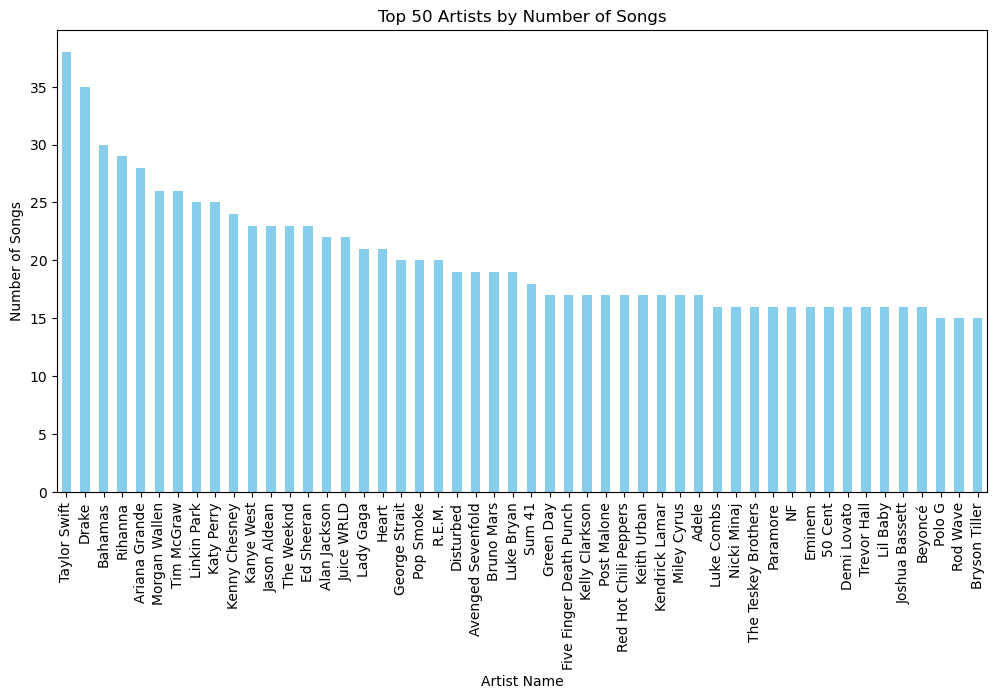

In [4]:
def plot_top_artists(songs_df):
    """
    Plots the top 50 artists based on the number of songs.

    Parameters:
    songs_df (DataFrame): A pandas DataFrame containing song data, including 'artist_name'.
    """
    
    # Count the number of songs per artist
    # The value_counts method counts the occurrences of each unique value in the 'artist_name' column
    artist_song_count = songs_df['artist_name'].value_counts()

    # Select the top 50 artists with the most songs
    # The head method returns the first n rows, here n is 50
    top_artists = artist_song_count.head(50)

    # Creating the bar chart using matplotlib
    plt.figure(figsize=(12, 6))
    top_artists.plot(kind='bar', color='skyblue')  # Plot a bar chart of the top artists
    plt.title('Top 50 Artists by Number of Songs')  # Title of the plot
    plt.xlabel('Artist Name')  # Label for the x-axis
    plt.ylabel('Number of Songs')  # Label for the y-axis
    plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
    plt.show()  # Display the plot

# Example usage
# songs_df = pd.read_csv('your_songs_data.csv')  # Load your DataFrame from a file
plot_top_artists(songs_df)  # Call the function with the DataFrame


This function, "plot_top_artists", takes a pandas DataFrame ("songs_df") as an input, which should contain a column named 'artist_name'. It calculates the number of songs for each artist, selects the top 50 artists based on this count, and then plots a bar chart to visualize this data. The x-axis of the chart shows the artist names, and the y-axis shows the number of songs. This is useful for quickly identifying which artists are most prevalent in your dataset.

Number of Songs    20.925759
dtype: float64


/var/folders/tx/m38yq8k57gs15658kl2q0c600000gn/T/ipykernel_94596/575132500.py:31: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(playlist_count_df.mean())


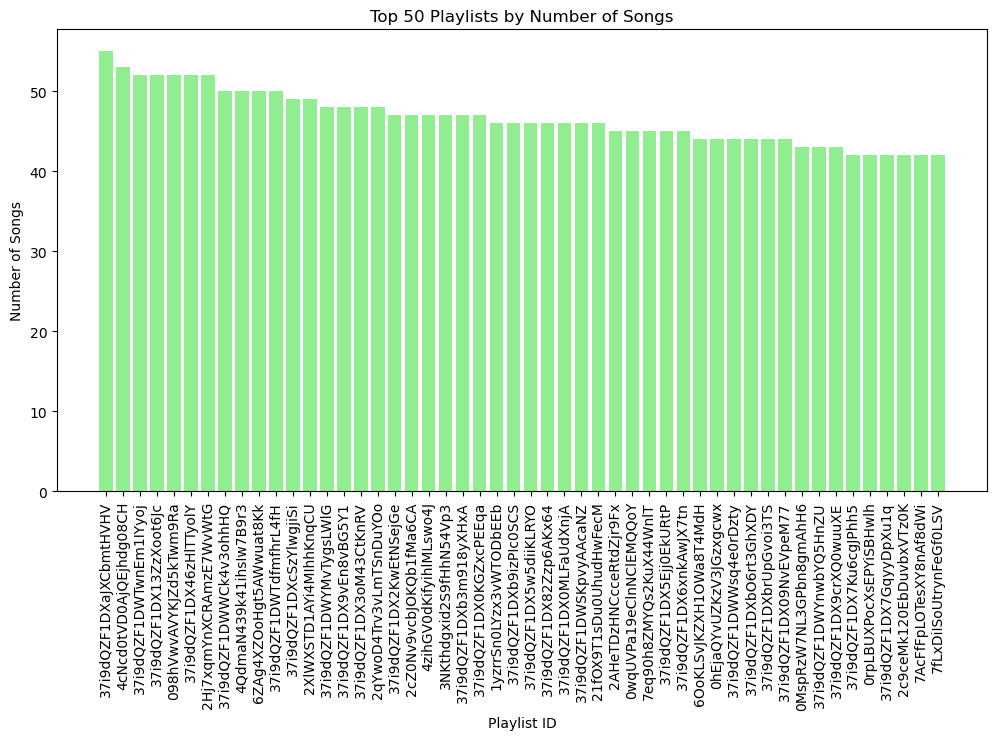

In [5]:
# Define a function to safely evaluate strings as Python literals
def safe_literal_eval(s):
    try:
        return literal_eval(s)  # Attempt to evaluate the string as a Python literal
    except ValueError:
        return []  # Return an empty list in case of a parsing error

# Convert the string representation of lists in the 'playlist' column to actual list objects
# This is necessary because the data is stored as strings but needs to be processed as lists
songs_df['playlist'] = songs_df['playlist'].apply(safe_literal_eval)

# Initialize a dictionary to count the number of songs in each playlist
playlist_song_count = {}
for playlists in songs_df['playlist']:
    for playlist in playlists:
        if playlist in playlist_song_count:
            playlist_song_count[playlist] += 1  # Increment the count for existing playlists
        else:
            playlist_song_count[playlist] = 1   # Initialize the count for new playlists

# Convert the playlist-song count dictionary to a DataFrame for easier data handling and plotting
playlist_count_df = pd.DataFrame(list(playlist_song_count.items()), columns=['Playlist ID', 'Number of Songs'])

# Sort the DataFrame by the number of songs in each playlist in descending order
playlist_count_df = playlist_count_df.sort_values(by='Number of Songs', ascending=False)

# Select the top 50 playlists for visualization
top_playlists = playlist_count_df.head(50)

# Print the average number of songs across all playlists for informational purposes
print(playlist_count_df.mean())

# Create a bar chart to visualize the top 50 playlists by number of songs
plt.figure(figsize=(12, 6))
plt.bar(top_playlists['Playlist ID'], top_playlists['Number of Songs'], color='lightgreen')
plt.title('Top 50 Playlists by Number of Songs')  # Set the title of the chart
plt.xlabel('Playlist ID')  # Label for the x-axis
plt.ylabel('Number of Songs')  # Label for the y-axis
plt.xticks(rotation=90)  # Rotate the x-axis labels for readability
plt.show()  # Display the plot

In [6]:
# Function to calculate diversity score for each playlist
def calculate_diversity(playlists, artists):
    diversity_scores = {}
    for playlist in set(playlists):
        # Counting the number of unique artists in each playlist
        unique_artists = len(set([artists[i] for i, p in enumerate(playlists) if p == playlist]))
        total_songs = sum([1 for p in playlists if p == playlist])
        # Calculating the diversity score (number of unique artists / total number of songs)
        diversity_scores[playlist] = unique_artists / total_songs if total_songs > 0 else 0
    return diversity_scores

# Flatten the list of playlists and corresponding artists
all_playlists = [playlist for playlists in songs_df['playlist'] for playlist in playlists]
all_artists = [artist for artist, playlists in zip(songs_df['artist_name'], songs_df['playlist']) for _ in playlists]

# Calculate the diversity score for each playlist
playlist_diversity_scores = calculate_diversity(all_playlists, all_artists)

# Convert the diversity scores to a dataframe for visualization
diversity_df = pd.DataFrame(list(playlist_diversity_scores.items()), columns=['Playlist ID', 'Diversity Score'])
diversity_df = diversity_df.sort_values(by='Diversity Score', ascending=False)

# Calculating the mean of the diversity scores
mean_diversity_score = diversity_df['Diversity Score'].mean()
mean_diversity_score

0.8199579970429197

## Apriori analysis

In [7]:
# Step 1: Create a list of transactions
playlist_dict = {}  # Dictionary to hold songs for each unique playlist

# Iterate over each song
for index, row in songs_df.iterrows():
    # Get the list of playlists for the current song
    playlists = row['playlist']
    for playlist in playlists:
        # Add the song to the corresponding playlist in the dictionary
        if playlist not in playlist_dict:
            playlist_dict[playlist] = set()
        playlist_dict[playlist].add(row['song_name'])

# Convert the dictionary into a list of transactions
transactions = [list(songs) for songs in playlist_dict.values()]

# Step 2: Apply TransactionEncoder
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_transactions = pd.DataFrame(te_ary, columns=te.columns_)

# Step 3: Apply Apriori Algorithm
frequent_itemsets = apriori(df_transactions, min_support=0.01, use_colnames=True)  # Adjust the support value as needed

# Step 4: Generate Association Rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)

# Display the first few association rules
rules = rules.sort_values(by='support', ascending=False)
rules


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
14,(Highway to Hell),(Back In Black),0.031496,0.029246,0.022497,0.714286,24.423077,0.021576,3.397638,0.990244
13,(Back In Black),(Highway to Hell),0.029246,0.031496,0.022497,0.769231,24.423077,0.021576,4.196850,0.987949
11,(As It Was),(Flowers),0.028121,0.038245,0.020247,0.720000,18.825882,0.019172,3.434839,0.974280
5,(When I Was Your Man),(All of Me),0.033746,0.034871,0.020247,0.600000,17.206452,0.019071,2.412823,0.974777
23,(California Gurls),(Starships),0.028121,0.039370,0.017998,0.640000,16.256000,0.016891,2.668416,0.965639
...,...,...,...,...,...,...,...,...,...,...
60,(The Kind of Love We Make),(Rock and A Hard Place),0.015748,0.015748,0.010124,0.642857,40.821429,0.009876,2.755906,0.991111
59,(Rock and A Hard Place),(The Kind of Love We Make),0.015748,0.015748,0.010124,0.642857,40.821429,0.009876,2.755906,0.991111
58,(Rock and A Hard Place),(Something in the Orange),0.015748,0.022497,0.010124,0.642857,28.575000,0.009769,2.737008,0.980444
55,(Party Rock Anthem),(Time of Our Lives),0.016873,0.037120,0.010124,0.600000,16.163636,0.009497,2.407199,0.954233


The dataset shows associations between different songs based on their appearance in Spotify playlists. Here's a detailed interpretation of the key findings from the first few rows:

"Back In Black" and "Highway to Hell" (AC/DC):

- Support: 2.25%, indicating these songs appear together in about 2.25% of all playlists in your dataset.
- Confidence: 76.92%, suggesting that when "Back In Black" is in a playlist, there's a 76.92% chance that "Highway to Hell" will also be in the same playlist.
- Lift: 24.42, a very high value, indicating a strong positive association between these songs. It means that the presence of one significantly increases the likelihood of the other being present.
- Interpretation: This strong association could be due to both songs being classic hits from AC/DC, appealing to fans of classic rock or a specific era of music.

"As It Was" and "Flowers":

- Support: 2.02%, found together in 2.02% of playlists.
- Confidence: 72%, meaning there's a 72% probability of finding "Flowers" in playlists that contain "As It Was".
- Lift: 18.83, another strong association.
- Interpretation: This might indicate a trend in listener preference for these songs together, perhaps due to a similar genre, mood, or recent popularity.

"When I Was Your Man" and "All of Me":

- Support: 2.02%.
- Confidence: 60%, so in 60% of the cases where "When I Was Your Man" is played, "All of Me" is also in the playlist.
- Lift: 17.21, suggesting a strong relationship.
- Interpretation: These songs may share thematic content or appeal to similar listener demographics, possibly due to their romantic or emotional content.

"California Gurls" and "Starships":

- Support: 1.80%.
- Confidence: 64%, indicating a fairly strong likelihood that "Starships" is in playlists that include "California Gurls".
- Lift: 16.26, suggesting these songs are more likely to be found together than by chance.
- Interpretation: This pairing might reflect a preference for a certain upbeat, pop genre or a specific period in music.

In [8]:
rules.to_csv("Apriori.csv")

In [9]:
# Assuming 'apriori_results' is your DataFrame with the association rules

# Step 1: Sort Rules by Confidence and Lift
sorted_rules = rules.sort_values(by=['confidence', 'lift'], ascending=False)

# Step 2: Filter for High-Quality Rules
# Define your thresholds
confidence_threshold = 0.9
lift_threshold = 1.5

# Filter the rules
high_quality_rules = sorted_rules[(sorted_rules['confidence'] >= confidence_threshold) & 
                                  (sorted_rules['lift'] >= lift_threshold)]

# Display the top 10 high-quality rules
high_quality_rules.head(20)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
54,(Paradise City),(Welcome To The Jungle),0.011249,0.016873,0.011249,1.000000,59.266667,0.011059,inf,0.994312
110,"(Have You Ever Seen The Rain, More Than a Feel...",(Highway to Hell),0.010124,0.031496,0.010124,1.000000,31.750000,0.009805,inf,0.978409
97,"(Back In Black, Have You Ever Seen The Rain)",(Highway to Hell),0.010124,0.031496,0.010124,1.000000,31.750000,0.009805,inf,0.978409
88,"(All of Me, Just the Way You Are)",(When I Was Your Man),0.010124,0.033746,0.010124,1.000000,29.633333,0.009782,inf,0.976136
89,"(Just the Way You Are, When I Was Your Man)",(All of Me),0.010124,0.034871,0.010124,1.000000,28.677419,0.009771,inf,0.975000
22,(Break Your Heart),(Starships),0.014623,0.039370,0.013498,0.923077,23.446154,0.012923,12.488189,0.971556
82,"(A Thousand Years, When I Was Your Man)",(All of Me),0.013498,0.034871,0.012373,0.916667,26.287634,0.011903,11.581552,0.975122
118,"(Replay, Time of Our Lives)",(Starships),0.012373,0.039370,0.011249,0.909091,23.090909,0.010761,10.566929,0.968679
120,"(You Proof, Something in the Orange)",(The Kind of Love We Make),0.011249,0.015748,0.010124,0.900000,57.150000,0.009947,9.842520,0.993680
67,(Whiskey On You),(She Had Me At Heads Carolina),0.011249,0.015748,0.010124,0.900000,57.150000,0.009947,9.842520,0.993680


Sort Rules by Confidence and Lift:

- "sorted_rules = rules.sort_values(by=['confidence', 'lift'], ascending=False)". This line sorts the association rules in the DataFrame based on two metrics: 'confidence' and 'lift'.
- The rules are first sorted by 'confidence', and then within each confidence level, they are sorted by 'lift'.
- The sorting is in descending order, so the rules with the highest confidence and lift values are at the top.

Filter for High-Quality Rules:

- First, thresholds for 'confidence' and 'lift' are defined (confidence_threshold and lift_threshold).
- The DataFrame sorted_rules is then filtered to select only those rules that meet or exceed these thresholds.
- This is done using a conditional statement that checks if the 'confidence' of each rule is greater than or equal to confidence_threshold and if the 'lift' is greater than or equal to lift_threshold.

Display the Top High-Quality Rules:

- high_quality_rules.head(20) displays the top 20 rules from this filtered set.
- These are the rules that are considered "high-quality" based on the specified thresholds for confidence and lift.

What This Code Achieves:
- The purpose of this code is to identify the strongest association rules in your dataset based on confidence and lift.
- High 'confidence' suggests that when the antecedent (left-hand side of the rule) is present, the consequent (right-hand side) is very likely to be present as well.
- A high 'lift' value indicates that the relationship between the antecedent and consequent is strong and not just due to chance.
- By sorting and filtering the rules in this way, you can pinpoint the most significant and reliable associations within your dataset, which can be valuable for understanding patterns or making predictions.

/var/folders/tx/m38yq8k57gs15658kl2q0c600000gn/T/ipykernel_94596/4289633653.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_rules['rule'] = top_rules.apply(lambda x: f"{set(x['antecedents'])} => {set(x['consequents'])}", axis=1)


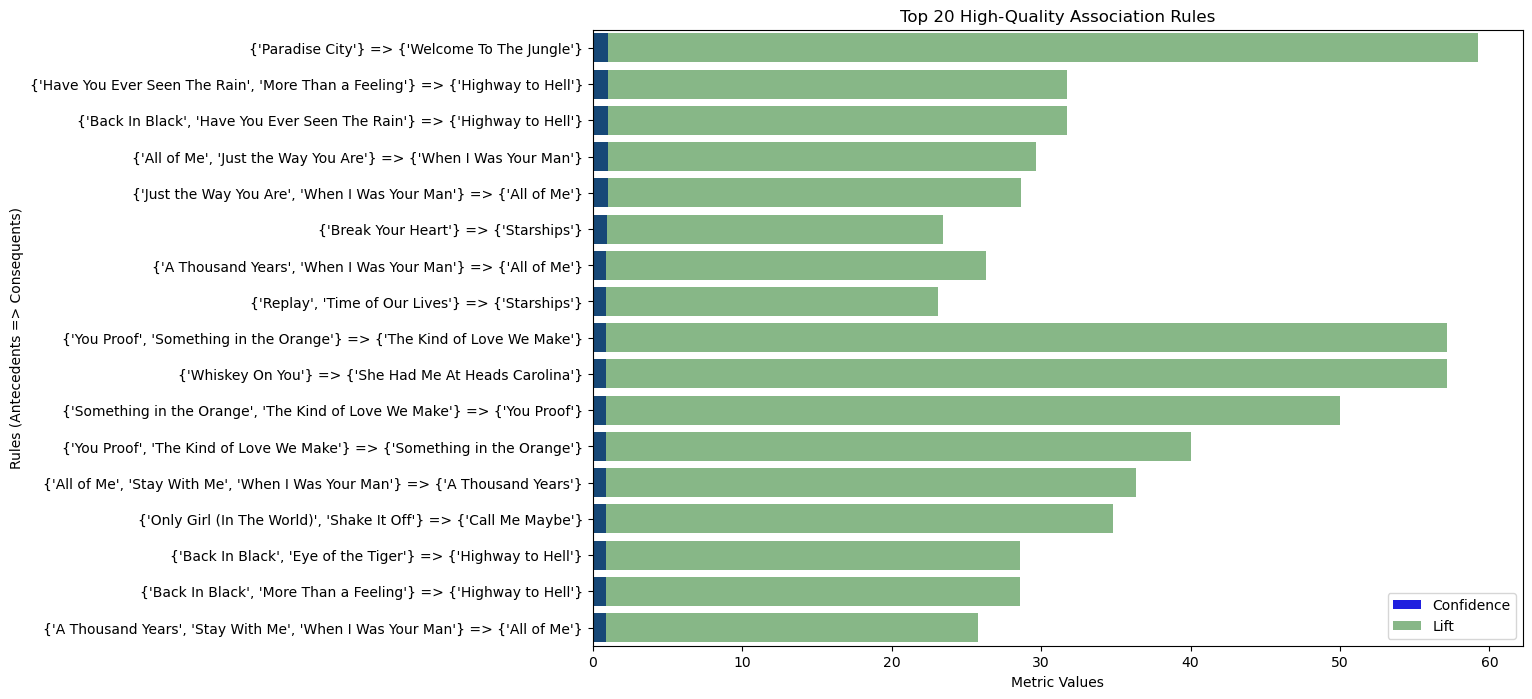

Insights Summary:
The above rules showcase the most significant song associations in our dataset.
High confidence values indicate strong predictive relationships between song pairs.
Elevated lift values suggest that these associations are not due to random chance.


In [28]:
# Select top 20 rules for visualization
top_rules = high_quality_rules.head(20)
# Create a new column combining antecedents and consequents
top_rules['rule'] = top_rules.apply(lambda x: f"{set(x['antecedents'])} => {set(x['consequents'])}", axis=1)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='confidence', y='rule', data=top_rules, color='blue', label='Confidence')
sns.barplot(x='lift', y='rule', data=top_rules, color='green', alpha=0.5, label='Lift')

plt.xlabel('Metric Values')
plt.ylabel('Rules (Antecedents => Consequents)')
plt.title('Top 20 High-Quality Association Rules')
plt.legend()
plt.show()

# Insights Summary
print("Insights Summary:")
print("The above rules showcase the most significant song associations in our dataset.")
print("High confidence values indicate strong predictive relationships between song pairs.")
print("Elevated lift values suggest that these associations are not due to random chance.")

In [63]:
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets.to_csv("temp1111.csv")

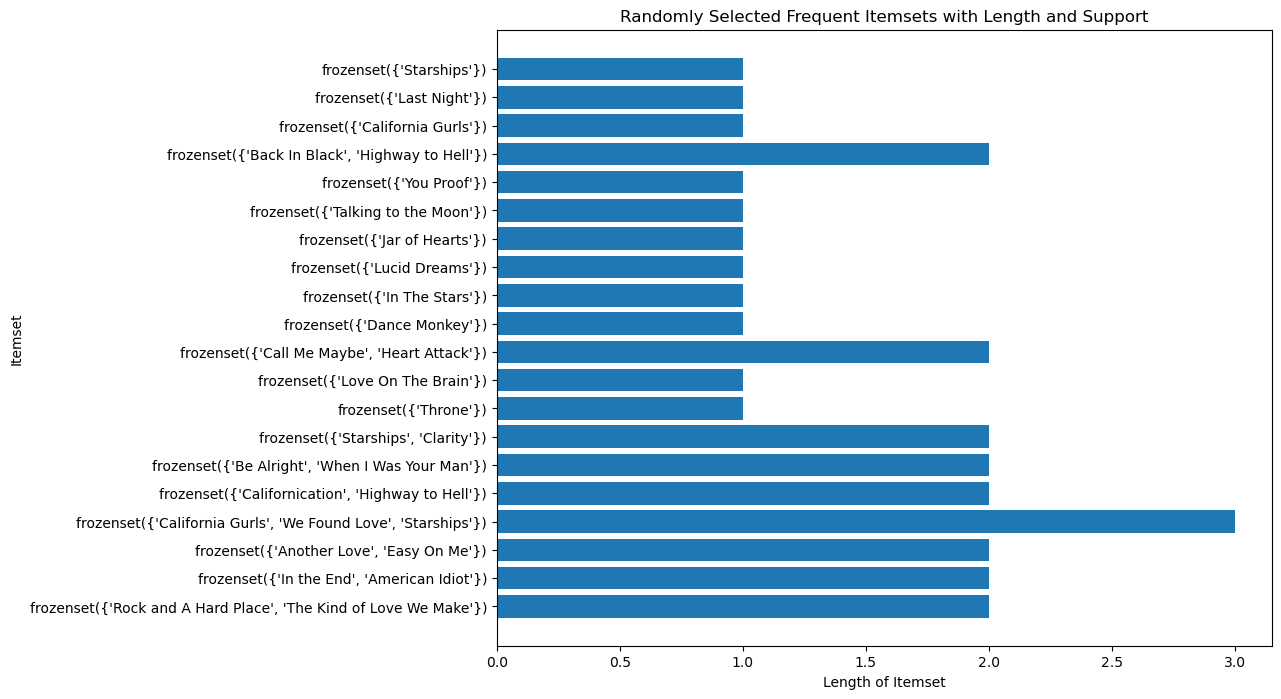

In [30]:
import random 
# Create a DataFrame from the sample data (replace with your actual data)
frequent_itemsets = pd.DataFrame(frequent_itemsets)

# Randomly select 20 itemsets to plot
random.seed(14)  # Set a seed for reproducibility
selected_itemsets = random.sample(range(len(frequent_itemsets)), 20)

# Subset the DataFrame with the selected itemsets
selected_frequent_itemsets = frequent_itemsets.iloc[selected_itemsets]

# Sort the selected DataFrame by support in descending order
selected_frequent_itemsets = selected_frequent_itemsets.sort_values(by='support', ascending=False)

# Create the bar chart
plt.figure(figsize=(10, 8))
plt.barh(range(len(selected_frequent_itemsets)), selected_frequent_itemsets['length'], tick_label=selected_frequent_itemsets['itemsets'])
plt.xlabel('Length of Itemset')
plt.ylabel('Itemset')
plt.title('Randomly Selected Frequent Itemsets with Length and Support')
plt.gca().invert_yaxis()  # Invert the y-axis for better readability
plt.show()

In [31]:
## import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates
import networkx as nx

# Function to clean the frozenset format in antecedents and consequents
def clean_frozenset(row):
    return str(row).replace("frozenset({'", "").replace("'})", "")

In [32]:
apriori_output = rules
# Clean up the antecedents and consequents for better visualization
apriori_output['antecedents'] = apriori_output['antecedents'].apply(clean_frozenset)
apriori_output['consequents'] = apriori_output['consequents'].apply(clean_frozenset)

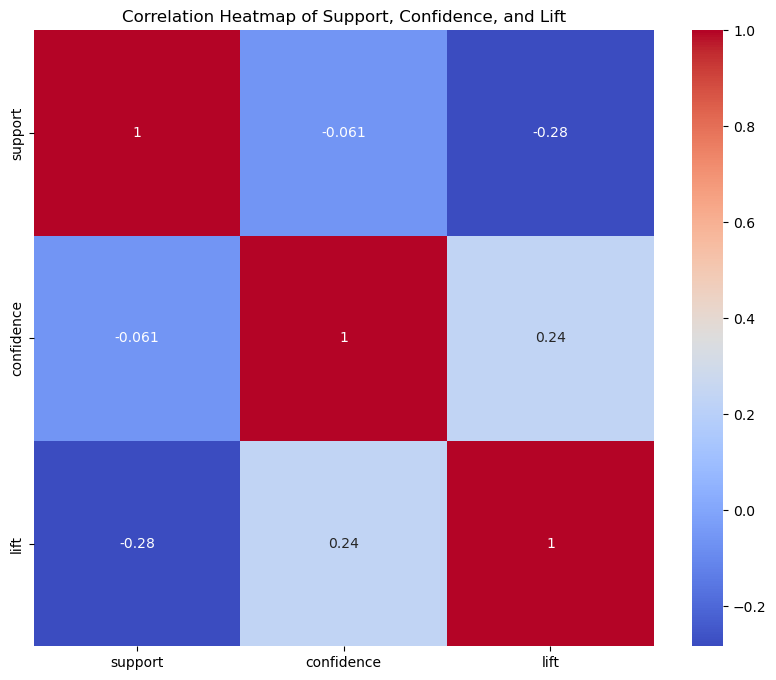

In [33]:
# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(apriori_output[['support', 'confidence', 'lift']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Support, Confidence, and Lift')
plt.show()

Correlation Heatmap of Support, Confidence, and Lift:

- This heatmap shows a red square at the intersection of 'support' with itself, indicating a perfect correlation, which is expected since any variable correlates perfectly with itself.
- There is a slightly negative correlation between support and lift, as indicated by the blue square, suggesting that more common rules (higher support) do not necessarily have a high lift.
- Confidence has a small positive correlation with lift but almost no correlation with support, which implies that the reliability of a rule (confidence) does not strongly depend on how frequently the items appear together (support), but it might lead to a moderately higher lift.

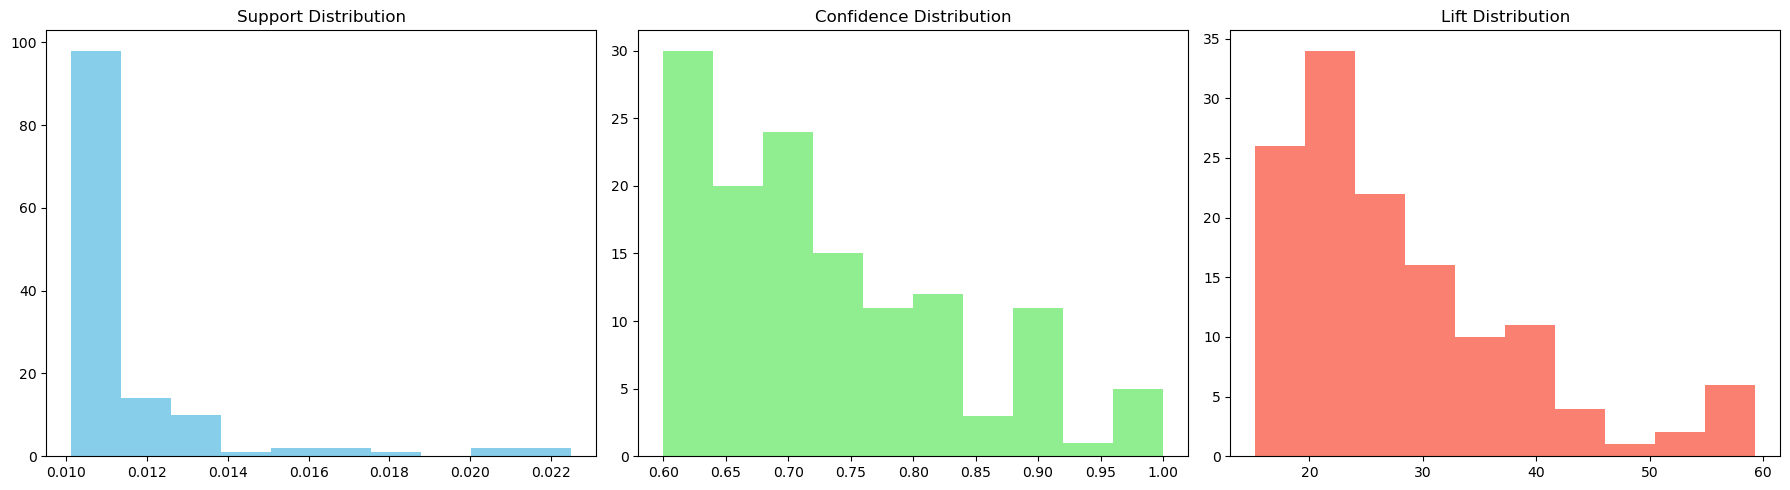

In [61]:
# Histograms
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
ax[0].hist(apriori_output['support'], bins=10, color='skyblue')
ax[0].set_title('Support Distribution')
ax[1].hist(apriori_output['confidence'], bins=10, color='lightgreen')
ax[1].set_title('Confidence Distribution')
ax[2].hist(apriori_output['lift'], bins=10, color='salmon')
ax[2].set_title('Lift Distribution')
plt.tight_layout()
plt.show()

Histograms (Support, Confidence, and Lift Distributions):

- The Support Distribution histogram shows a large number of rules with low support, indicating that most item combinations do not appear together frequently.
- The Confidence Distribution histogram displays a range of confidence levels, with a peak suggesting that a substantial number of rules have a medium to high level of confidence.
- The Lift Distribution histogram has a wide range, with several peaks, indicating that while some rules have very high lift values, others are closer to what would be expected if the items were independent.

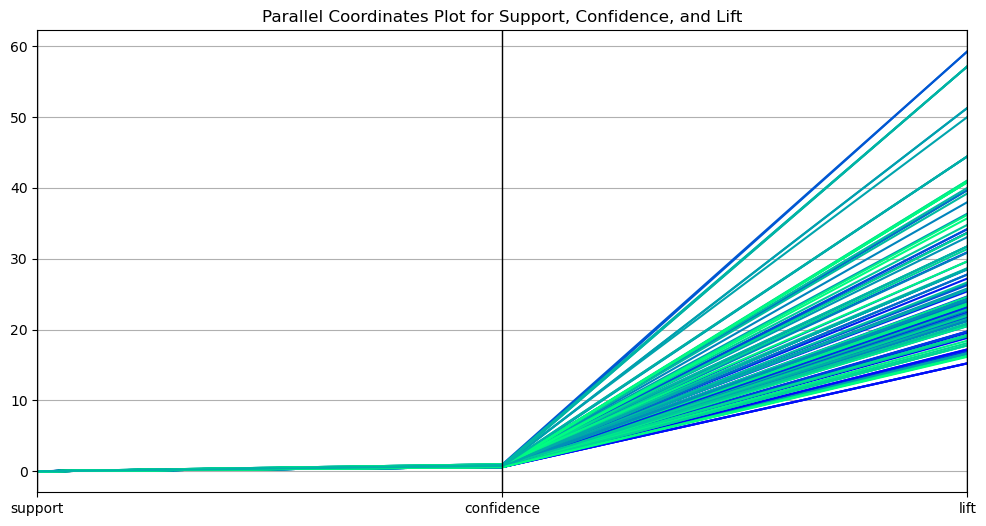

In [62]:
# Parallel Coordinates Plot
plt.figure(figsize=(12, 6))
parallel_coordinates(apriori_output[['support', 'confidence', 'lift']], class_column='lift', cols=['support', 'confidence', 'lift'], colormap='winter')
plt.title('Parallel Coordinates Plot for Support, Confidence, and Lift')
plt.legend().set_visible(False)
plt.show()

Parallel Coordinates Plot for Support, Confidence, and Lift:

- The lines in the plot represent individual rules, showing their respective support, confidence, and lift values.
- Most lines start at the lower end of the support axis, rise through the confidence axis, and then spread across the lift axis, indicating a variety of lift values across the rules.

In [36]:
# Re-importing the data
apriori_results = apriori_output

# Function to manually parse the strings in 'antecedents' and 'consequents' columns
def parse_string(s):
    # Removing the "frozenset" and braces
    s = s.replace("frozenset({", "").replace("})", "")
    # Splitting by comma and stripping extra whitespace and quotes
    return [item.strip().strip("'") for item in s.split(',')]

# Apply the parsing function
apriori_results['antecedents'] = apriori_results['antecedents'].apply(parse_string)
apriori_results['consequents'] = apriori_results['consequents'].apply(parse_string)

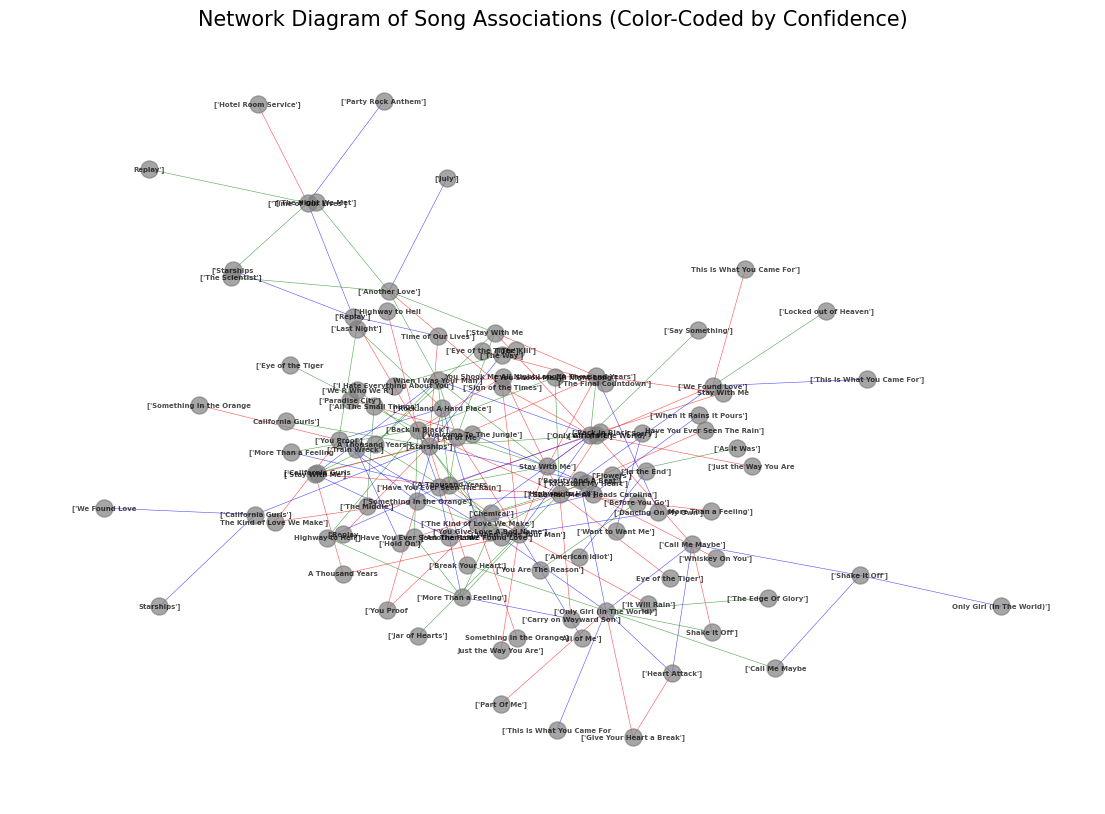

In [52]:
# Extracting pairs of associations along with the confidence values
associations_with_confidence = []
for index, row in apriori_results.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            # Append the pair along with the confidence value
            associations_with_confidence.append((antecedent, consequent, row['confidence']))


# Create the network graph
G = nx.Graph()
for src, dst, confidence in associations_with_confidence:
    if confidence > 0.75:  # Adjust the threshold as needed
        edge_color = 'red'  # Strong connection
    elif confidence > 0.65:  # Adjust the threshold as needed
        edge_color = 'green'  # Neutral connection
    else:
        edge_color = 'blue'  # Other connection
    G.add_edge(src, dst, color=edge_color)

# Extracting edge colors for drawing
edge_colors = [G[u][v]['color'] for u, v in G.edges()]
# Using Kamada-Kawai layout for the graph
pos = nx.kamada_kawai_layout(G)

# Draw the network graph
plt.figure(figsize=(14, 10))
nx.draw_networkx(G, pos, with_labels=True, node_color='grey', edge_color=edge_colors, font_weight='bold', 
                 node_size=150, font_size=5, width=0.4, alpha=0.7)
plt.title("Network Diagram of Song Associations (Color-Coded by Confidence)", fontsize=15)
plt.axis('off')
plt.show()


The resulting plot is a network diagram where nodes represent songs, and edges represent the associations between these songs.
The color of each edge indicates the strength of the association based on the confidence level, providing a visual representation of which song associations are stronger or weaker in your dataset.
In summary, this code visually maps out how songs are related to each other based on the confidence of their associations, offering an insightful way to understand the relationships and trends within your dataset.

# Lyric sentiment analysis

## Data labeling

### Lyric preprocessing & Sentiment annotation

Read data from local csv

In [1]:
file_path = "YOUR-FILEPATH"
df = pd.read_csv(file_path)

Clean lyrics from the following:
* \n
* [something]

Also explored invalid urls

In [68]:
def clean_lyrics(lyrics):
    # Remove text within brackets
    cleaned_lyrics = re.sub(r"\[.*?\]|\(.*?\)", "", lyrics)

    # Capitalize the first letter of each line
    cleaned_lyrics = cleaned_lyrics.replace('\n', " ")
    cleaned_lyrics = cleaned_lyrics.strip(" ")

    return cleaned_lyrics

In [69]:
# Apply the cleaning function to your DataFrame
df['lyrics'] = df['lyrics'].apply(clean_lyrics)

After data exploration, we realize that some extra and more custom cleaning is needed

In [70]:
# this url is not the url of a song
df.drop(df.loc[df['lyrics_url'] == 'https://genius.com/Scopey-almost-every-album-ive-listened-to-lyrics'].index, inplace = True)
df.drop(df.loc[df['lyrics_url'] == 'https://genius.com/Hossein-amini-drive-annotated'].index, inplace = True)
df.drop(df.loc[df['lyrics_url'] == 'https://genius.com/Genius-valentines-day-playlists-lyrics'].index, inplace = True)


Label songs based on their lyric sentiments.

Used textblob library

In [88]:
# Function to apply sentiment analysis using TextBlob
def get_sentiment(lyrics):
    try:
        blob = TextBlob(lyrics)
        # TextBlob returns polarity and subjectivity, you can use just polarity for a simple positive/negative/neutral sentiment
        polarity = blob.sentiment.polarity
        if polarity > 0:
            return "Positive"
        elif polarity < 0:
            return "Negative"
        else:
            return "Neutral"
    except Exception as e:
        print(f"Error processing lyrics: {e}")
        return None
    

def clean_lyrics(lyric):
    cleaned_lyrics = re.sub()

In [89]:
%%time
df['sentiment'] = df['lyrics'].apply(lambda lyrics: get_sentiment(lyrics))


CPU times: total: 23.2 s
Wall time: 55.2 s


#### Lyric descriptives

In [90]:
rows = len(df)
average_length = df['lyrics'].str.len().mean()
average_words = df['lyrics'].apply(lambda x: len(x.split())).mean()
print("Lyric descriptives")
print("--------------------------")
print(f"Number of songs: {rows}")
print(f"Average number of characters in a song's lyrics: {average_length}")
print(f"Average number of words in a song's lyrics: {average_words}")

Lyric descriptives
--------------------------
Number of songs: 10514
Average number of characters in a song's lyrics: 1895.2707818147233
Average number of words in a song's lyrics: 376.53671295415637


In [91]:
print("Dataset Distribution")
print("---------------------")
print(f"Precentage of negative labels: {len(df[df['sentiment']=='Negative'])/len(df) * 100}%")
print(f"Precentage of positive labels: {len(df[df['sentiment']=='Positive'])/len(df) * 100}%")
print(f"Precentage of neutral labels: {len(df[df['sentiment']=='Neutral'])/len(df) * 100}%")

Dataset Distribution
---------------------
Precentage of negative labels: 31.12992200875024%
Precentage of positive labels: 67.26269735590641%
Precentage of neutral labels: 1.6073806353433517%


### Train classifiers

#### Balancing our dataset & vectorization

Since the neutral reviews are so few there is no point in keeping them in the dataset

In [92]:
df_neg_pos = df[df['sentiment'] !='Neutral']

In [93]:
print("New Dataset Distribution")
print("---------------------")
print(f"Precentage of negative labels: {len(df_neg_pos[df_neg_pos['sentiment']=='Negative'])/len(df_neg_pos) * 100}%")
print(f"Precentage of positive labels: {len(df_neg_pos[df_neg_pos['sentiment']=='Positive'])/len(df_neg_pos) * 100}%")

New Dataset Distribution
---------------------
Precentage of negative labels: 31.6384726921218%
Precentage of positive labels: 68.3615273078782%


In [18]:
# Encode labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_neg_pos['sentiment'])

# Preprocessing with TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Adjust the number of features as needed
X_tfidf = tfidf_vectorizer.fit_transform(df_neg_pos['lyrics'])
y = y_encoded

# Split your data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Initialize RandomUnderSampler
under_sampler = RandomUnderSampler(random_state=42)

# Apply undersampling to the training data
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)

**Algorithm selection**

We keep in mind the computational resources needed for the algorithms. Maybe we don't end up with the stringest model, but we aim for the most feasibly reliable one.

| Algorithm | Pros | Cons |
|-----------|------|------|
| **SVM (Support Vector Machine)** | - Effective in high-dimensional spaces<br> - Works well with a clear margin of separation<br> - Less prone to overfitting | - Not suitable for very large datasets<br> - Requires feature scaling<br> - Can be less effective with overlapping classes |
| **Naive Bayes** | - Fast and efficient<br> - Works well with high-dimensional data<br> - Effective for text classification | - Based on the assumption of feature independence<br> - Can be outperformed by more complex models |
| **Logistic Regression** | - Simple and easy to implement<br> - Efficient for binary classification tasks<br> - Provides probabilities for outcomes | - Can struggle with complex relationships in data<br> - Not the best choice for non-linear problems |
| **Random Forest** | - Handles non-linear data well<br> - Less prone to overfitting<br> - Good for classification and regression | - Can be slow on large datasets<br> - Model interpretability can be challenging |
| **LSTM (Long Short-Term Memory)** | - Excellent for sequence data like text<br> - Can capture long-term dependencies<br> - Good for complex language modeling | - Computationally intensive<br> - Requires large training datasets<br> - Longer training times |
| **BERT (Bidirectional Encoder Representations from Transformers)** | - State-of-the-art for NLP tasks<br> - Understands word context and nuances<br> - Highly accurate for various language tasks | - Requires significant computational resources<br> - Complex and requires fine-tuning<br> - Overkill for simpler tasks |


**SVM, Naive Bayes, Logistic Regression, and Random Forest**: These are traditional machine learning models and are generally less complex and computationally intensive compared to LSTM and BERT. They can be effective for smaller datasets or less complex sentiment analysis tasks but might not capture the intricacies of language as effectively as LSTM or BERT.

**LSTM and BERT**: These are advanced deep learning models that excel in understanding language context and complexities. They are more suitable for large datasets and complex NLP tasks, but their need for significant computational resources and longer training times can be a drawback, especially in resource-constrained environments.

#### SVM

Grid search

In [25]:
%%time
# Define the model
svm_model = SVC()

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Kernel type
    'gamma': ['scale', 'auto']  # Kernel coefficient
}

# Grid search with cross-validation
grid_search = GridSearchCV(svm_model, param_grid, cv=5, verbose=2, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train_under, y_train_under)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
CPU times: total: 28.4 s
Wall time: 6min 19s


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             verbose=2)

Best parameter selection

In [26]:
# Best parameters and best score
svm_best_parameters = grid_search.best_params_
svm_best_score = grid_search.best_score_

print("Best Parameters:", svm_best_parameters)
print("Best Score:", svm_best_score)

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Score: 0.8016125578734175


Model Evaluation

In [27]:
best_svm = grid_search.best_estimator_
test_accuracy = best_svm.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.8144030932817786


#### Naive Bayes

Grid search

In [28]:
%%time
# Define the model
nb_model = MultinomialNB()

# Define the parameter grid
# Naive Bayes usually has fewer hyperparameters to tune, but you can experiment with alpha
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100]  # Additive (Laplace/Lidstone) smoothing parameter
}

# Grid search with cross-validation
grid_search = GridSearchCV(nb_model, param_grid, cv=5, verbose=2, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train_under, y_train_under)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
CPU times: total: 15.6 ms
Wall time: 240 ms


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100]}, verbose=2)

Best parameter selection

In [29]:
nb_best_parameters = grid_search.best_params_
nb_best_score = grid_search.best_score_

print("Best Parameters:", nb_best_parameters)
print("Best Score:", nb_best_score)

Best Parameters: {'alpha': 1}
Best Score: 0.7013873824542189


Model Evaluation

In [30]:
best_nb = grid_search.best_estimator_
test_accuracy = best_nb.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.7414209763170614


#### Logistic Regression

Grid search

In [31]:
%%time
log_reg_model = LogisticRegression()


param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']  # Algorithm to use in optimization
}

# Grid search with cross-validation
grid_search = GridSearchCV(log_reg_model, param_grid, cv=5, verbose=2, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train_under, y_train_under)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
CPU times: total: 688 ms
Wall time: 7.39 s


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             verbose=2)

Best parameter selection

In [32]:
lr_best_parameters = grid_search.best_params_
lr_best_score = grid_search.best_score_

print("Best Parameters:", lr_best_parameters)
print("Best Score:", lr_best_score)

Best Parameters: {'C': 10, 'solver': 'saga'}
Best Score: 0.8122904008227765


Model Evaluation

In [33]:
best_lr = grid_search.best_estimator_
test_accuracy = best_lr.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.8231029482841953


### Model comparison

In [37]:
# dict of all the models
best_estimators = {
    'SVM': best_svm,
    'Naive Bayes': best_nb,
    'Logistic Regression': best_lr,
#     'Random Forest': best_rf
}

Dummy classifier as baseline model

In [38]:
# Assuming X_train, X_test, y_train, y_test are already defined
# Implement the Dummy Classifier
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)
dummy_predictions = dummy_clf.predict(X_test)

# Add the Dummy Classifier to your best estimators dictionary
best_estimators['Dummy Classifier'] = dummy_clf

#### Metrics table

In [39]:
# Generate predictions for all models
predictions = {model: estimator.predict(X_test) for model, estimator in best_estimators.items()}

# Initialize a dictionary to hold the metrics
metrics_summary = {}

# Calculate metrics for all models
for model, model_predictions in predictions.items():
    accuracy = accuracy_score(y_test, model_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, model_predictions, average='weighted')
    metrics_summary[model] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

# Display the metrics for each model including the Dummy Classifier
for model, metrics in metrics_summary.items():
    print(f"{model} - Accuracy: {metrics['Accuracy']}, Precision: {metrics['Precision']}, Recall: {metrics['Recall']}, F1 Score: {metrics['F1 Score']}")

SVM - Accuracy: 0.8144030932817786, Precision: 0.8366713244592203, Recall: 0.8144030932817786, F1 Score: 0.8200886257226082
Naive Bayes - Accuracy: 0.7414209763170614, Precision: 0.7493681326869763, Recall: 0.7414209763170614, F1 Score: 0.7447846190703241
Logistic Regression - Accuracy: 0.8231029482841953, Precision: 0.8419559537515556, Recall: 0.8231029482841953, F1 Score: 0.8281002651608682
Dummy Classifier - Accuracy: 0.7080715321411309, Precision: 0.5013652946286886, Recall: 0.7080715321411309, F1 Score: 0.5870542131221035


C:\Users\artem\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrict table to be copy pasted into overleaf to save time <3 

In [40]:
# Convert metrics_summary to a DataFrame
metrics_df = pd.DataFrame(metrics_summary).transpose()

# Convert the DataFrame to a LaTeX table
latex_table = metrics_df.to_latex(float_format="%.2f", header=True, index=True)

# Printing the LaTeX table
print(latex_table)

\begin{tabular}{lrrrr}
\toprule
 & Accuracy & Precision & Recall & F1 Score \\
\midrule
SVM & 0.81 & 0.84 & 0.81 & 0.82 \\
Naive Bayes & 0.74 & 0.75 & 0.74 & 0.74 \\
Logistic Regression & 0.82 & 0.84 & 0.82 & 0.83 \\
Dummy Classifier & 0.71 & 0.50 & 0.71 & 0.59 \\
\bottomrule
\end{tabular}



**Explanation**

**Results from Undersampled Models**

*SVM (Support Vector Machine)*:

Accuracy: 81.44% - A good percentage of the predictions are correct.
Precision: 83.67% - When it predicts a label, it is correct about 83.67% of the time.
Recall: 81.44% - It correctly identifies 81.44% of all true positive and negative instances.
F1 Score: 82.01% - A balance between precision and recall, indicating good overall performance.

*Naive Bayes*:

Accuracy: 74.14% - Lower than SVM and Logistic Regression.
Precision: 74.94% - Slightly higher precision compared to its accuracy.
Recall: 74.14% - Similar to accuracy, indicating consistent performance across classes.
F1 Score: 74.48% - Reflects a balance between precision and recall.

*Logistic Regression*:

Accuracy: 82.31% - The highest among the models.
Precision: 84.20% - Indicates a strong ability to correctly label positive and negative instances.
Recall: 82.31% - Consistent with its accuracy.
F1 Score: 82.81% - Shows a good balance between precision and recall.

*Dummy Classifier*:

Accuracy: 70.81% - As a baseline, it's predictably lower but not by a wide margin.
Precision: 50.14% - Low precision indicates a high number of false positives.
Recall: 70.81% - Identical to accuracy, expected for a model predicting the most frequent class.
F1 Score: 58.71% - Lower, reflecting the imbalance between precision and recall.

**Interpretation and Comparison**

Improved Balanced Performance: The SVM and Logistic Regression models show an overall balanced performance in terms of accuracy, precision, recall, and F1 score. This suggests effective handling of both positive and negative classes after undersampling.

Logistic Regression's Superiority: Logistic Regression slightly outperforms SVM in all metrics, making it potentially the best model among those tested.

Naive Bayes' Lower Performance: Naive Bayes lags behind SVM and Logistic Regression, indicating it might be less suited for this particular task or data distribution.

Dummy Classifier as Baseline: The Dummy Classifier serves as a baseline, and its lower performance compared to other models 
validates their effectiveness.

Effect of Undersampling: The improved balance in precision and recall in the SVM and Logistic Regression models compared to the Dummy Classifier suggests that undersampling helped in addressing the class imbalance issue.
Comparison with Initial Attempt: If these results show an improvement over your initial attempt without sampling, it indicates that addressing the class imbalance was beneficial. Specifically, look for improvements in precision and recall for the minority class, which are often most affected by class imbalance.

In summary, undersampling appears to have helped in balancing the performance of your models across different metrics, with Logistic Regression showing the best overall performance. These models now likely offer a more reliable understanding of their ability to generalize to new data, particularly in a more balanced real-world scenario.

#### Confusion Matrix

In [48]:
# Mapping for your labels
label_mapping = {0: 'negative', 1: 'positive'}

for model_name, y_pred in predictions.items():
    # Generate the confusion matrix for the current model
    cm = confusion_matrix(y_test, y_pred)

    # Calculate the mislabeling percentage for each label
    mislabeling_percentages = np.sum(cm, axis=1) - np.diag(cm)
    mislabeling_percentages = mislabeling_percentages / np.sum(cm, axis=1) * 100

    print(f"\nMislabeling percentages for {model_name}:")
    for label_idx, mislabel_pct in enumerate(mislabeling_percentages):
        label_name = label_mapping.get(label_idx, f"Label {label_idx}")
        print(f"Label {label_name}: {mislabel_pct:.2f}% mislabeled")


Mislabeling percentages for SVM:
Label negative: 17.88% mislabeled
Label positive: 18.84% mislabeled

Mislabeling percentages for Naive Bayes:
Label negative: 39.40% mislabeled
Label positive: 20.27% mislabeled

Mislabeling percentages for Logistic Regression:
Label negative: 17.88% mislabeled
Label positive: 17.61% mislabeled

Mislabeling percentages for Dummy Classifier:
Label negative: 100.00% mislabeled
Label positive: 0.00% mislabeled


The adjustments made to balance the classes have led to a more equitable performance between the negative and positive labels. Previously, the models were more biased towards correctly identifying the positive (majority) class, while the negative (minority) class saw higher rates of mislabeling. The balanced approach has notably improved the ability of models, especially Naive Bayes and SVM, to correctly classify the negative instances, leading to a more reliable and fair performance across classes.

This analysis underscores the importance of addressing class imbalance in datasets, especially when dealing with models that are sensitive to such disparities. It highlights how balancing techniques can lead to a more accurate and unbiased assessment of a model's predictive capabilities.

**Comparison with Imbalanced Results**
1. Improved Balance: The balanced models show a more even performance between the negative and positive classes. The imbalanced dataset had a tendency for lower mislabeling in the positive class (the majority class) and higher mislabeling in the negative class.
2. Overall Improvement: In the balanced dataset, all models (except for the Dummy Classifier) show a reduced mislabeling rate for the negative class, indicating that balancing the dataset has improved their ability to correctly identify negative instances.
3. Consistent Performance in Positive Class: The performance in identifying positive labels remains relatively good and more balanced after undersampling, as seen in the reduced mislabeling rates for SVM and Logistic Regression.
4. Naive Bayes: This model shows the most significant improvement in the negative class, indicating that the balancing had a notable positive effect on its performance.

#### Statistical testing

We are conducting further statistical testing between our two top persorming models.

First we are conducting a Shapiro-Wilk test with H0: "Differences between the two models' scores seem to be normally distributed (fail to reject H0)". If we failt to reject H0 then we can proceed with the paired t-test for these models, as the normality assumption required for the paired t-test is satisfied.

In [50]:
# Obtain cross-validation scores for each model
scores_lr = cross_val_score(best_lr, X_tfidf, y, cv=5)
scores_svm = cross_val_score(best_svm, X_tfidf, y, cv=5)

# Calculate differences between sets of scores
score_diffs = scores_lr - scores_svm

# Shapiro-Wilk Test for Normality
stat, p = shapiro(score_diffs)
alpha = 0.05
if p > alpha:
    print('Differences seem to be normally distributed (fail to reject H0)')
else:
    print('Differences do not appear to be normally distributed (reject H0)')

Differences seem to be normally distributed (fail to reject H0)


Interpreting the Shapiro-Wilk test result "Differences seem to be normally distributed (fail to reject H0)" in the context of comparing your best_lr (Logistic Regression) and best_svm (Support Vector Machine) models indicates that the differences in their cross-validation scores do not significantly deviate from a normal distribution. This means you can proceed with the paired t-test for these models, as the normality assumption required for the paired t-test is satisfied.

Now let's perform a paired t-test to determine if the differences in performance between the models are statistically significant

In [51]:
t_stat, p_value = ttest_rel(scores_lr, scores_svm)

print(f"Paired t-test between Logistic Regression and SVM:\nT-statistic: {t_stat}, P-value: {p_value}")

Paired t-test between Logistic Regression and SVM:
T-statistic: 6.491434997263605, P-value: 0.002904180302547974


**Statistical Significance**: Since the p-value is less than the typical alpha level of 0.05, you can reject the null hypothesis. This means that the difference in performance between the Logistic Regression and SVM models is statistically significant.

**Model Comparison**: The positive t-statistic suggests that the mean cross-validation score of the Logistic Regression model is higher than that of the SVM model. This indicates that Logistic Regression performs better than SVM on your dataset, and the difference in their performances is not just due to random chance.


In summary, this result suggests that Logistic Regression not only performs better than SVM on average but that this better performance is statistically significant and unlikely to be due to random fluctuations in the dataset. This provides a solid basis for preferring Logistic Regression over SVM in this particular case, assuming the other factors like model interpretability, complexity, and computational requirements also align with your project's needs.

------------------------
Corresponding latex table:

\begin{table}[h]
\centering
\begin{tabular}{|l|l|l|}
\hline
\textbf{Model Comparison} & \textbf{T-Statistic} & \textbf{P-Value} \\ \hline
Logistic Regression vs SVM & 6.491 & 0.0029 \\ \hline
\end{tabular}
\caption{Paired T-Test Results Between Logistic Regression and SVM}
\label{tab:paired_t_test}
\end{table}


In summary, this result indicates that Logistic Regression is not only performing better than SVM on average, but that this better performance is statistically significant and not likely due to random chance or variability in the dataset.

## Classification Modeling

# Audio feature based clustering

In [ ]:
file_path = "YOUR-FILEPATH"
songs_df = pd.read_csv(file_path)
songs_df.dropna(subset=['valence'], inplace=True)

# Plotting the dataset

We used James A. Russell's Circumplex Model of Affect to analyze songs. This model uses two main metrics: valence (how positive or negative an emotion is) and arousal (how energetic or calm it is). We applied it to songs using valence and energy data from Spotify, where valence (0 to 1) indicates how positive a song is, and energy (also 0 to 1) serves as a substitute for arousal to show how energetic a song is. Using these metrics, we plotted each song on a map with four quadrants. This plot visually categorizes songs into areas such as high valence and high energy (happy and energetic songs), or low valence and low energy (sad and calm songs), helping us understand the emotional character of each song in our dataset.

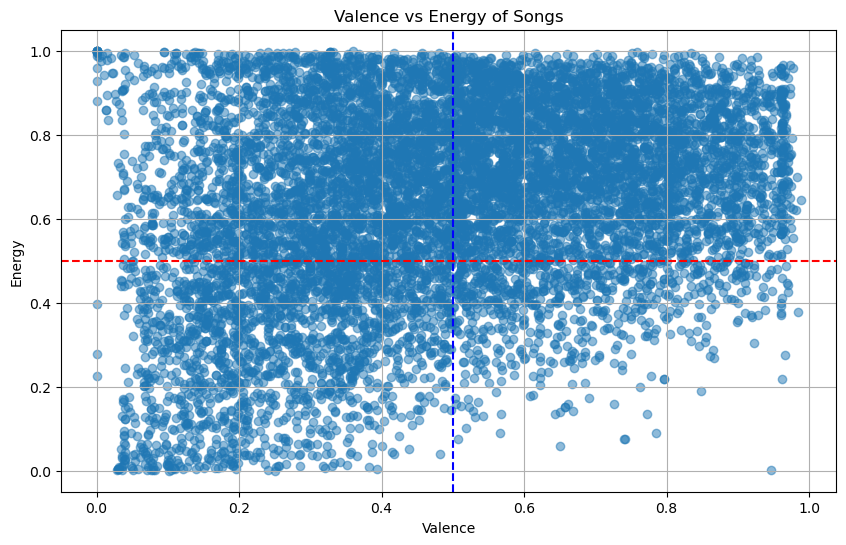

In [39]:
# Creating a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(songs_df['valence'], songs_df['energy'], alpha=0.5)

# Add reference lines at x=0.5 and y=0.5
plt.axhline(0.5, color='red', linestyle='--', label='y = 0.5')
plt.axvline(0.5, color='blue', linestyle='--', label='x = 0.5')
    
plt.title('Valence vs Energy of Songs')
plt.xlabel('Valence')
plt.ylabel('Energy')
plt.grid(True)
plt.show()

# Performing Clustering

To further explore this dataset, which includes song characteristics like valence and energy, we decided to run a few clustering algorithms. Based on valence and energy and the model of emotions, our songs are already categorized into 4 quadrants (happy, angry, sad, relaxed). But, is it possible to identify the same groups of data using a clustering method? Or will the clustering result in a different categorization?

To find out the answer, we used 3 different clustering algorithms: hierarchical clustering, k-means clustering and dbscan.

In [40]:
def hierarchical_clustering(n_clusters):
    # Read data
    points = list(zip(songs_df['valence'], songs_df['energy']))
    
    # Convert the list of points to a NumPy array
    points = np.array(points)
    
    # Perform hierarchical clustering
    clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(points)

    # Visualize the clusters
    plt.scatter(points[:, 0], points[:, 1], c=clustering.labels_, cmap='rainbow')
    plt.axhline(0.5, color='red', linestyle='--', label='y = 0.5')
    plt.axvline(0.5, color='blue', linestyle='--', label='x = 0.5')
    plt.title('Hierarchical Clustering')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.grid(True)
    plt.show()
    
def kmeans_clustering(n_clusters):
    # Read data
    points = list(zip(songs_df['valence'], songs_df['energy']))
    
    # Convert the list of points to a NumPy array
    points = np.array(points)
    
    # Perform k-Means clustering
    kmeans = KMeans(n_clusters=n_clusters).fit(points)

    # Visualize the clusters
    plt.scatter(points[:, 0], points[:, 1], c=kmeans.labels_, cmap='rainbow')
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='black', label='Centroids')
    plt.axhline(0.5, color='red', linestyle='--', label='y = 0.5')
    plt.axvline(0.5, color='blue', linestyle='--', label='x = 0.5')
    plt.title('k-Means Clustering')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.grid(True)
    plt.legend()
    plt.show()
    
def dbscan_clustering(eps, min_samples):
    # Read data
    points = list(zip(songs_df['valence'], songs_df['energy']))
    
    # Convert the list of points to a NumPy array
    points = np.array(points)
    
    # Perform DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(points)

    # Visualize the clusters (assuming -1 represents noise points)
    plt.scatter(points[:, 0], points[:, 1], c=dbscan.labels_, cmap='rainbow')
    plt.axhline(0.5, color='red', linestyle='--', label='y = 0.5')
    plt.axvline(0.5, color='blue', linestyle='--', label='x = 0.5')
    plt.title('DBSCAN Clustering')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.grid(True)
    plt.show()

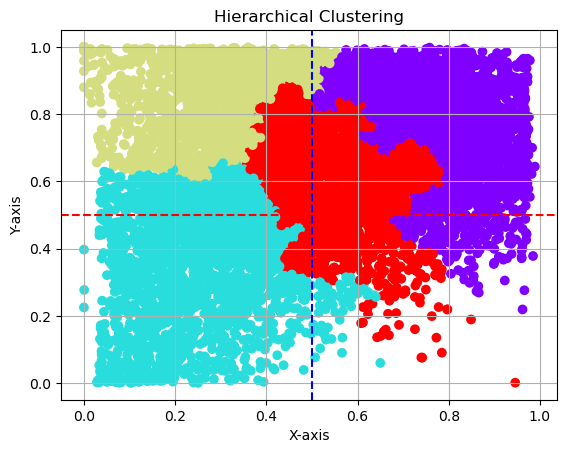

In [41]:
num_clusters_hierarchical = 4
hierarchical_clustering(num_clusters_hierarchical)

C:\Users\frena\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


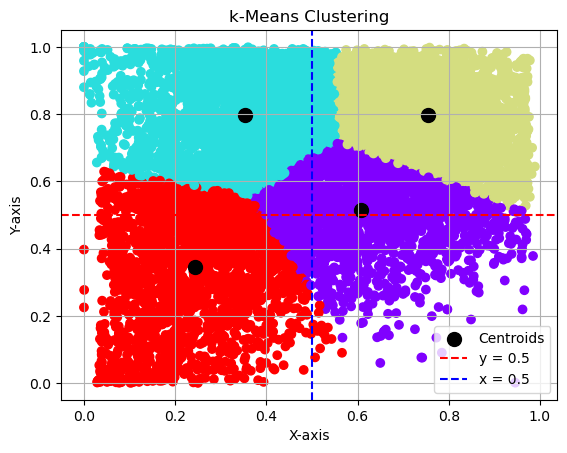

In [42]:
num_clusters_kmeans = 4
kmeans_clustering(num_clusters_kmeans)

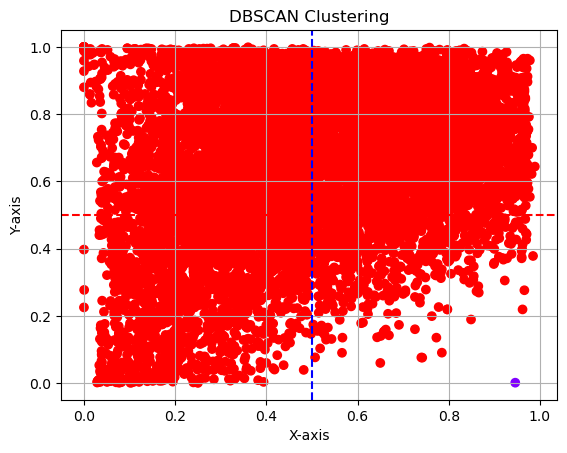

In [43]:
eps_dbscan = 0.1
min_samples_dbscan = 4
dbscan_clustering(eps_dbscan, min_samples_dbscan)      

Based on the results, it can be observed that the clusters vaguely match the quadrants after a small change of place of the axis. The mismatch might suggest that there is significant overlap between our categories. For instance, some songs might exhibit qualities of both 'happy' and 'relaxed' or 'angry' and 'sad', making them difficult to categorize distinctly.

## Comparing clustering to sentiment labels

### Plotting clustering vs sentiment values

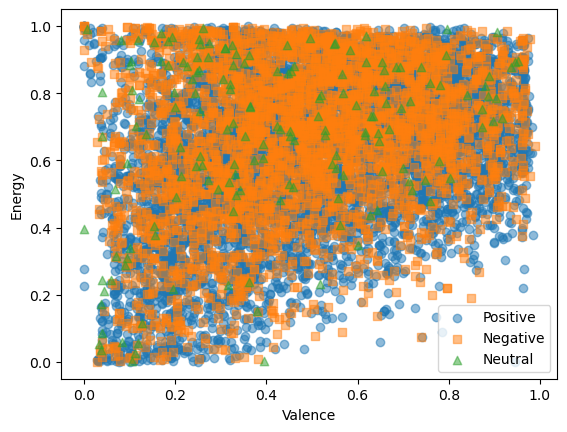

In [35]:
# Define node shapes for sentiments
shapes = {'Positive': 'o', 'Negative': 's', 'Neutral': '^'}  # Add more if needed

# Initialize the plot
fig, ax = plt.subplots()

# Plot each sentiment with a different shape
for sentiment, shape in shapes.items():
    subset = songs_df[songs_df['sentiment'] == sentiment]
    ax.scatter(subset['valence'], subset['energy'], alpha=0.5, marker=shape, label=sentiment)

# Setting the axis labels
ax.set_xlabel('Valence')
ax.set_ylabel('Energy')

# Adding a legend
ax.legend()

# Show the plot
plt.show()

### Percentage of sentiment in clusters

In [36]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt

# Assuming songs_df is your DataFrame and it already exists with a 'sentiment' column.

def calculate_sentiment_percentages(cluster_labels, sentiments):
    # Create a DataFrame with cluster labels and sentiments
    cluster_sentiment_df = pd.DataFrame({'Cluster': cluster_labels, 'Sentiment': sentiments})
    
    # Calculate the count of sentiments in each cluster
    sentiment_counts = cluster_sentiment_df.groupby(['Cluster', 'Sentiment']).size().unstack(fill_value=0)
    
    # Calculate the percentage of each sentiment within each cluster
    sentiment_percentages = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100
    return sentiment_percentages

def kmeans_clustering(songs_df, n_clusters):
    # Perform k-Means clustering
    kmeans = KMeans(n_clusters=n_clusters).fit(songs_df[['valence', 'energy']])
    # Get the percentage of sentiments in each cluster
    sentiment_percentages = calculate_sentiment_percentages(kmeans.labels_, songs_df['sentiment'])
    return sentiment_percentages

def hierarchical_clustering(songs_df, n_clusters):
    # Perform hierarchical clustering
    clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(songs_df[['valence', 'energy']])
    # Get the percentage of sentiments in each cluster
    sentiment_percentages = calculate_sentiment_percentages(clustering.labels_, songs_df['sentiment'])
    return sentiment_percentages

# Example usage:
kmeans_sentiment_percentages = kmeans_clustering(songs_df, n_clusters=4)
print(kmeans_sentiment_percentages)

hierarchical_sentiment_percentages = hierarchical_clustering(songs_df, n_clusters=4)
print(hierarchical_sentiment_percentages)

C:\Users\frena\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Sentiment   Negative   Neutral   Positive
Cluster                                  
0          34.905961  2.199554  62.894485
1          28.425965  1.527365  70.046669
2          30.688935  1.356994  67.954071
3          29.071395  1.166589  69.762016
Sentiment   Negative   Neutral   Positive
Cluster                                  
0          28.517442  1.395349  70.087209
1          29.600779  1.298280  69.100941
2          36.432844  2.827624  60.739532
3          32.868433  1.348210  65.783357
